In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.chdir('../../')

In [3]:
from src.numpy_encode import *
from src.utils.file_processing import process_all, process_file
from src.config import *
from src.music_transformer import *

# Generate Music with Pretrained Model

### Load Pretrained

In [14]:
# Config
config = default_config()

# Location of your midi files
midi_path =  Path('data/midi/examples')

# Location of saved datset
data_path = Path('data/numpy')
data_save_name = 'musicitem_data_save.pkl'

In [6]:
# Data
data = load_data(data_path, data_save_name)
vocab = data.vocab

In [7]:
# Pretrained Model
# Download pretrained model if you haven't already
pretrained_url = 'https://ashaw-midi-web-server.s3-us-west-2.amazonaws.com/pretrained'
pretrained_path = untar_data(pretrained_url, dest=data_path)
load_path = pretrained_path/'MusicTransformer.pth'; load_path

PosixPath('data/numpy/pretrained/MusicTransformer.pth')

In [8]:
# Learner
learn = music_model_learner(data, config.copy(), pretrained_path=load_path)

## Prediction

#### Choose existing midi file as a starting point

In [15]:
midi_files = get_files(midi_path, recurse=True, extensions='.mid'); midi_files[:4]

[PosixPath('data/midi/examples/Levels - Avicii - Verse.mid'),
 PosixPath('data/midi/examples/Colors Of The Wind - Disney - Chorus.mid'),
 PosixPath('data/midi/examples/Where Is The Love - Black Eyed Peas - Chorus.mid'),
 PosixPath('data/midi/examples/La Bamba - Ritchie Valen - Chorus.mid')]

In [33]:
idx = 4
f = midi_files[idx]; f

PosixPath('data/midi/examples/I Want You Back - Jackson 5 - Intro.mid')

#### NextWord/Autocomplete

Trim the song to only a few notes. Model will use these notes a seed and continue the idea

In [38]:
cutoff_beat = 10

item = MusicItem.from_file(f, data.vocab)
seed_item = item.trim_to_beat(cutoff_beat)

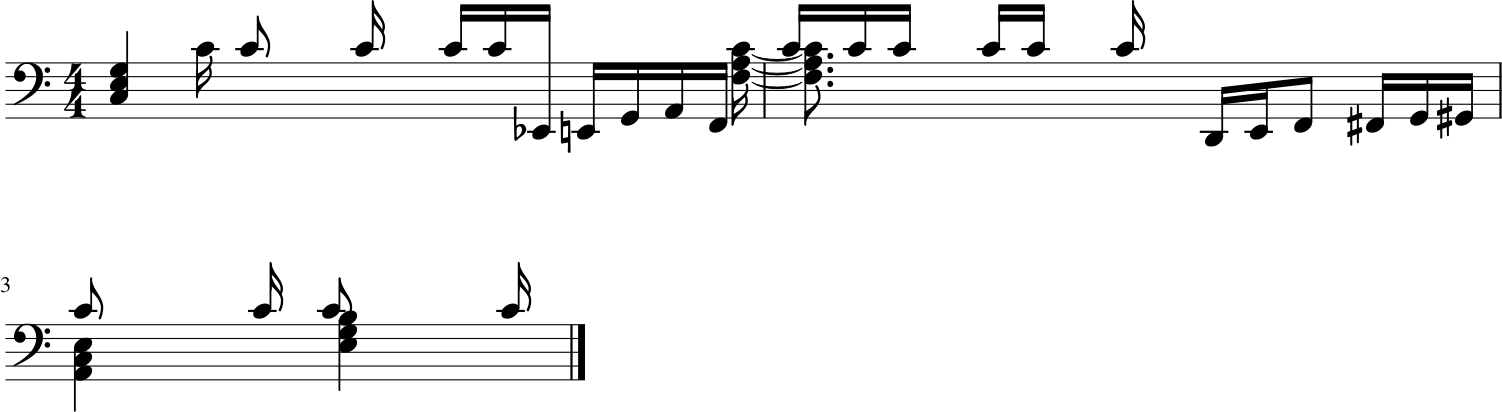

In [39]:
seed_item.show()

In [40]:
seed_item.play()

#### Use seed to predict next sequence

In [46]:
pred = learn.predict(seed_item, n_words=400, temperatures=(1.1,0.4), min_bars=12, top_k=24, top_p=0.7)

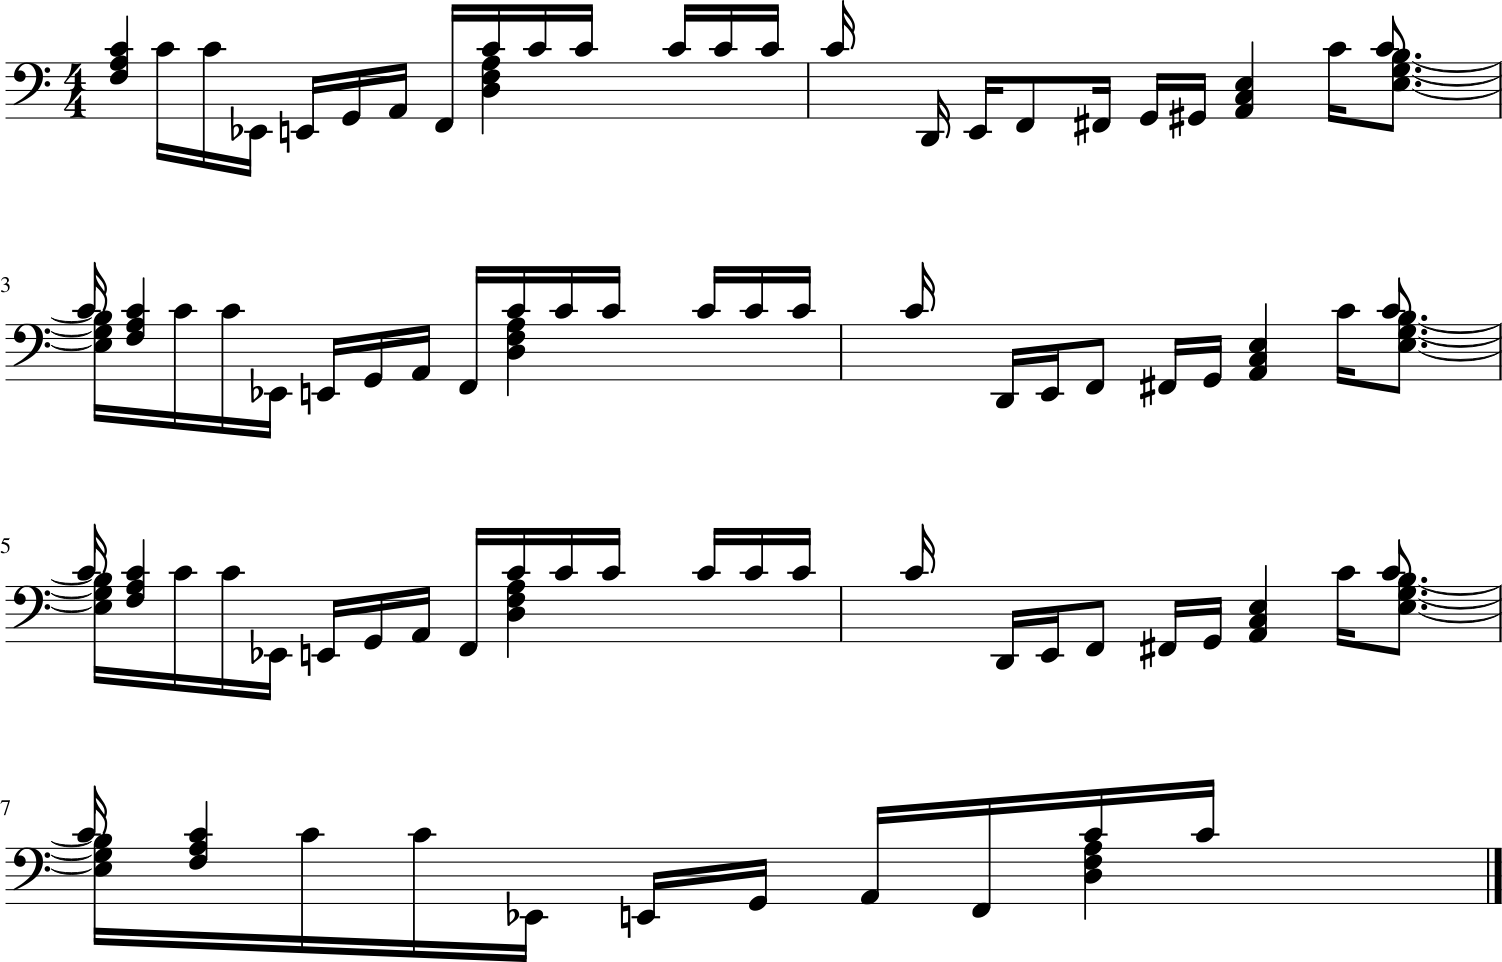

In [47]:
pred.show()

In [48]:
pred.play()

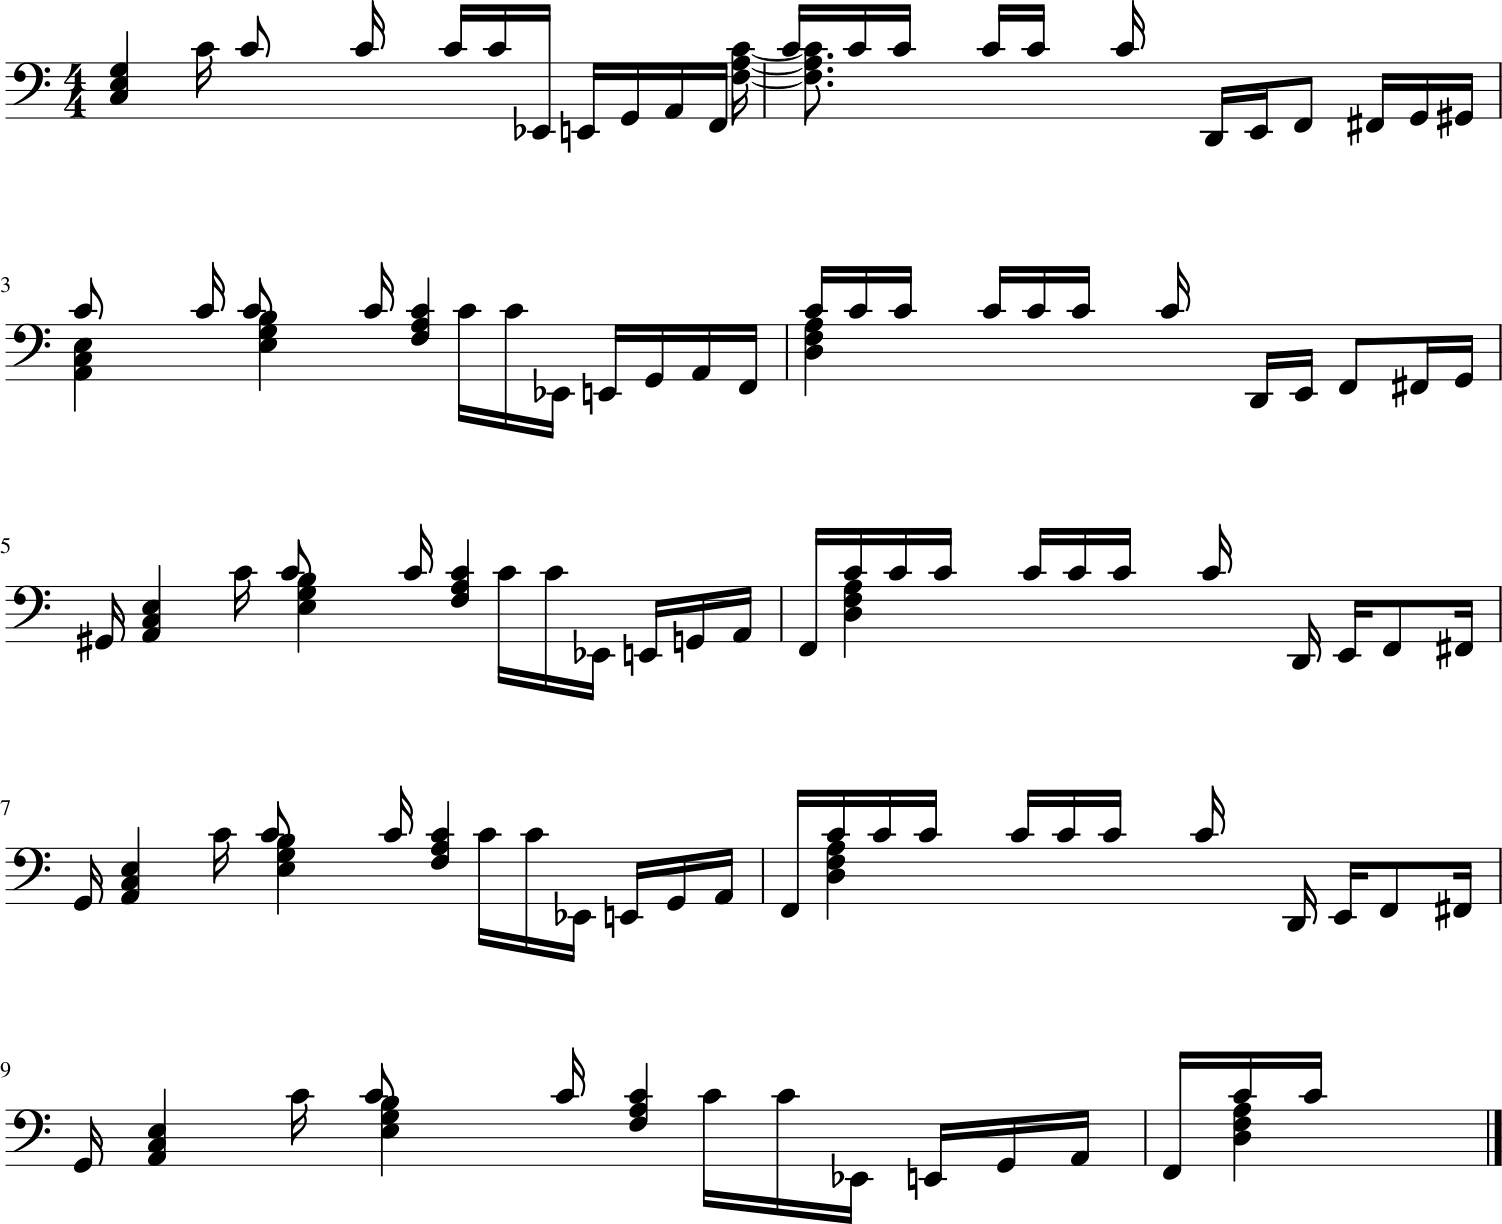

In [49]:
full_song = seed_item.append(pred); full_song.show()

In [50]:
full_song.play()

#### Add More Randomness to prediction

In [51]:
note_temp = 1.4 # Determines amount of variation in note pitches
dur_temp = 0.8 # Amount of randomness in rhythm
top_k = 30
pred = learn.predict(seed_item, n_words=400, temperatures=(note_temp, dur_temp), min_bars=12, top_k=top_k, top_p=0.7)

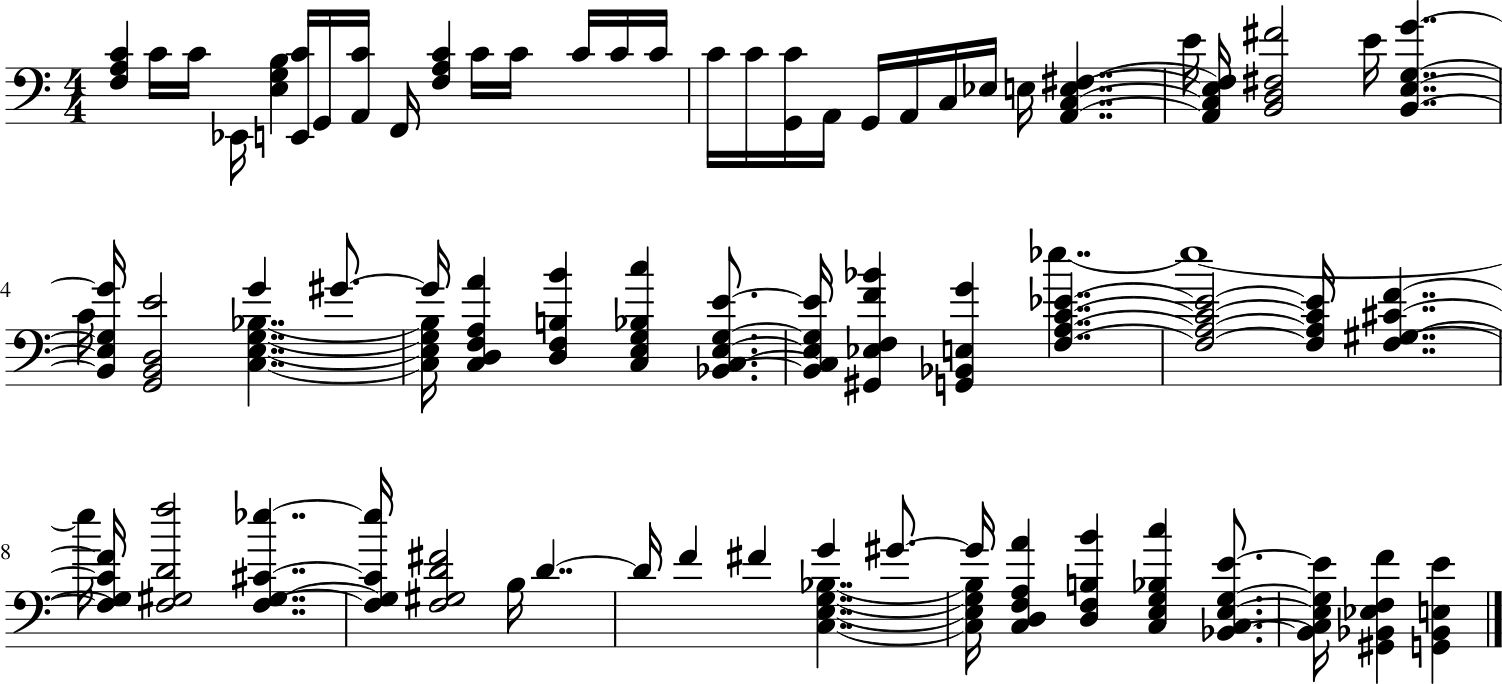

In [52]:
pred.show()

#### Predict without a starting sequence

In [53]:
empty_item = MusicItem.empty(vocab)

In [54]:
pred = learn.predict(empty_item, n_words=200)

Predicted BOS token. Returning prediction...


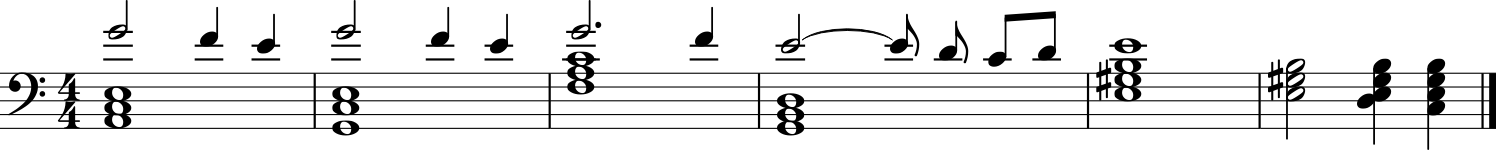

In [55]:
pred.show()